In [50]:
import os

os.makedirs('outputs', exist_ok=True)
os.makedirs('csv_files', exist_ok=True)
os.makedirs('notebooks', exist_ok=True)

In [51]:
!pip install pandas numpy matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [52]:
# Load Data
trader_file = '/content/historical_data.csv'
sentiment_file = '/content/fear_greed_index.csv'

try:
    trader_df = pd.read_csv(trader_file, low_memory=False)
    sentiment_df = pd.read_csv(sentiment_file)
    print("Data loaded successfully.")
except Exception as e:
    print(f" ERROR LOADING FILES: {e}")
    print(" Please check the file paths above and make sure they match your uploaded files.")

Data loaded successfully.


In [53]:
# Clean Sentiment Data
if 'sentiment_df' in locals():
    sentiment_map = {
        'Extreme Fear': 'Fear',
        'Fear': 'Fear',
        'Neutral': 'Neutral',
        'Greed': 'Greed',
        'Extreme Greed': 'Greed'
    }
    sentiment_df['sentiment_simple'] = sentiment_df['classification'].map(sentiment_map)
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
    sentiment_df_final = sentiment_df[['date', 'sentiment_simple', 'value']].copy()
    print("Sentiment Data cleaning complete.")
else:
    print("Sentiment data not found. Skipping cleaning.")

Sentiment Data cleaning complete.


In [54]:
# Clean Trader Data
if 'trader_df' in locals():
    trader_df_cleaned = trader_df.dropna().copy()
    cross_map = {'TRUE': True, True: True, 'FALSE': False, False: False}
    trader_df_cleaned['Crossed'] = trader_df_cleaned['Crossed'].map(cross_map)
    trader_df_cleaned['datetime'] = pd.to_datetime(trader_df_cleaned['Timestamp'], unit='ms')
    trader_df_cleaned['merge_date'] = pd.to_datetime(trader_df_cleaned['datetime'].dt.date)
    print("Trader Data cleaning complete.")
else:
    print("Trader data not found. Skipping cleaning.")

Trader Data cleaning complete.


In [55]:
# Merge Data & Feature Engineering
if 'trader_df_cleaned' in locals() and 'sentiment_df_final' in locals():
    merged_df = pd.merge(
        trader_df_cleaned,
        sentiment_df_final,
        left_on='merge_date',
        right_on='date',
        how='left'
    )
    merged_df_profitable = merged_df[merged_df['Closed PnL'] != 0].copy()
    merged_df_profitable['is_win'] = np.where(merged_df_profitable['Closed PnL'] > 0, 1, 0)
    analysis_df = merged_df_profitable.dropna(subset=['sentiment_simple']).copy()
    print("Merging and Feature Engineering complete.")
    print(f"Total trades for analysis: {len(analysis_df)}")
else:
    print("Cleaned dataframes not found. Skipping merge and feature engineering.")

Merging and Feature Engineering complete.
Total trades for analysis: 90755



Overall Market vs. Sentiment

Total PnL (Sum) by Sentiment:
 sentiment_simple
Fear      6699925.19
Neutral    158742.38
Greed     3366582.03
Name: Closed PnL, dtype: float64

Average Win Rate (Mean) by Sentiment:
 sentiment_simple
Fear      0.86
Neutral   0.81
Greed     0.84
Name: is_win, dtype: float64

Total Trading Volume (Sum USD) by Sentiment:
 sentiment_simple
Fear      347687803.44
Neutral    10981690.92
Greed      75902507.86
Name: Size USD, dtype: float64

Average Trade Size (Mean USD) by Sentiment:
 sentiment_simple
Fear      5387.50
Neutral   3905.30
Greed     3242.73
Name: Size USD, dtype: float64


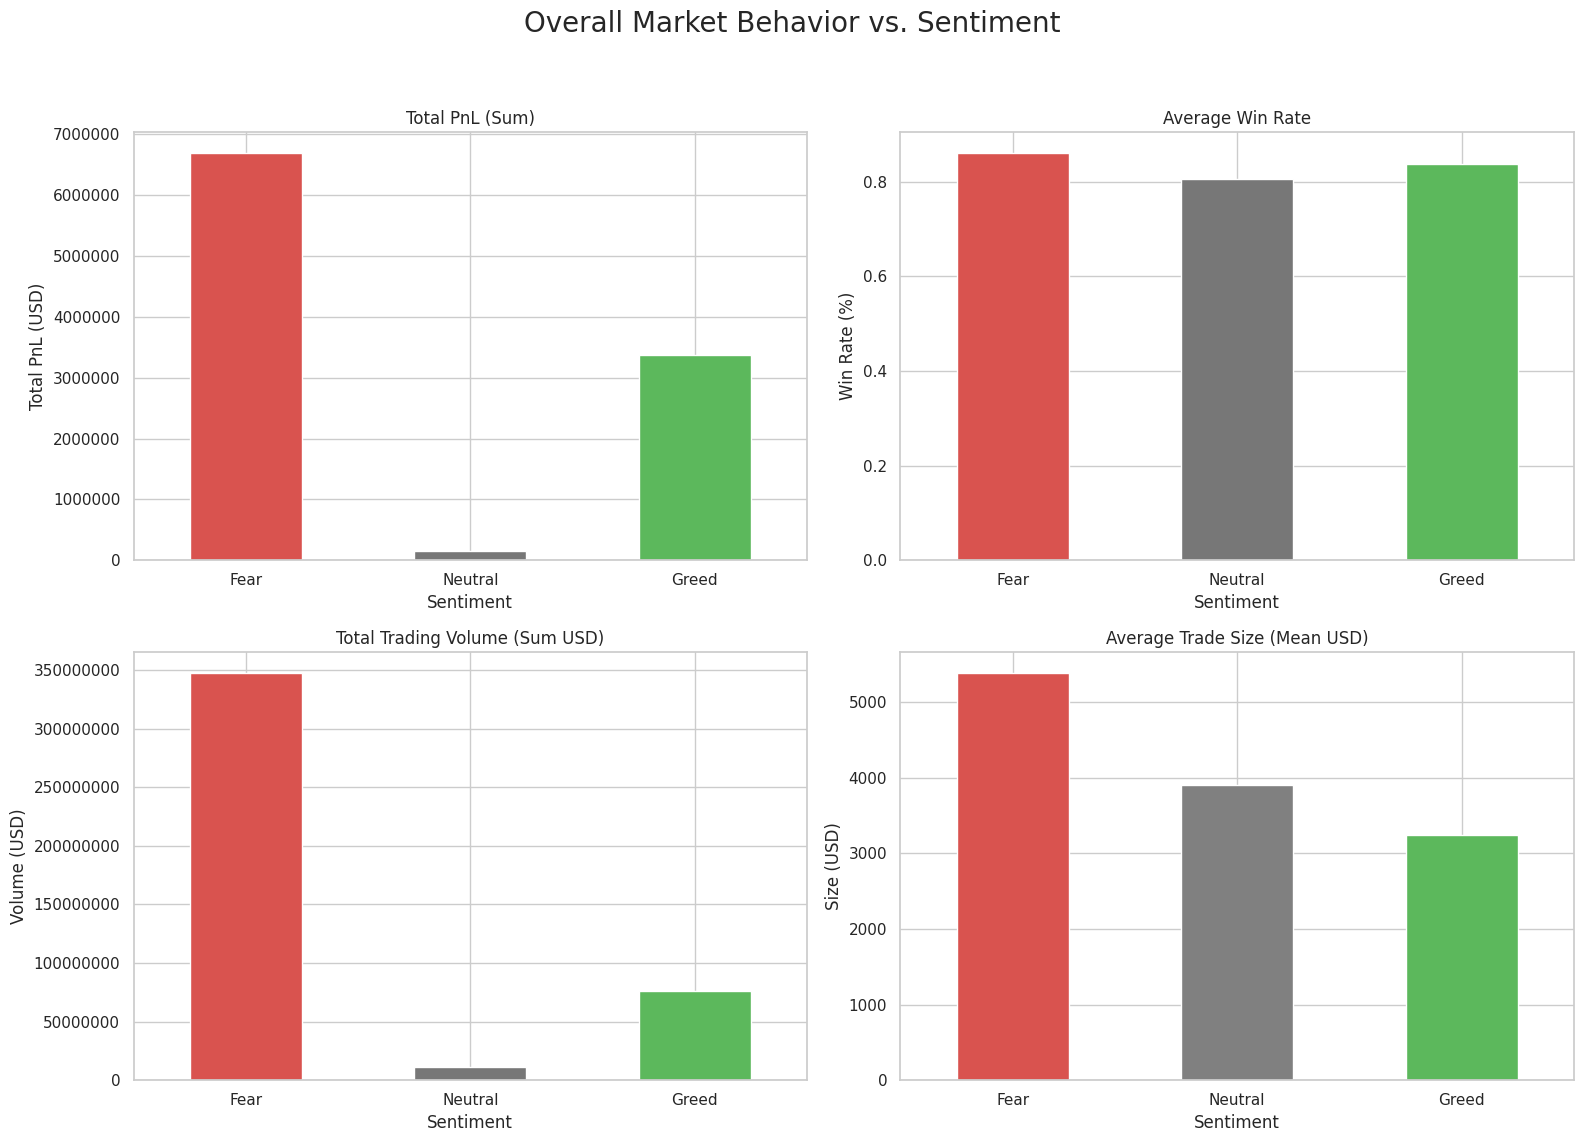

Chart 1 saved to outputs/market_behavior_plot.png


In [56]:
# Overall Market vs. Sentiment
if 'analysis_df' in locals():
    print("\nOverall Market vs. Sentiment")
    sentiment_order = ['Fear', 'Neutral', 'Greed']
    pnl_summary = analysis_df.groupby('sentiment_simple')['Closed PnL'].sum().reindex(sentiment_order)
    win_rate_summary = analysis_df.groupby('sentiment_simple')['is_win'].mean().reindex(sentiment_order)
    volume_summary = analysis_df.groupby('sentiment_simple')['Size USD'].sum().reindex(sentiment_order)
    avg_trade_size_summary = analysis_df.groupby('sentiment_simple')['Size USD'].mean().reindex(sentiment_order)

    print("\nTotal PnL (Sum) by Sentiment:\n", pnl_summary)
    print("\nAverage Win Rate (Mean) by Sentiment:\n", win_rate_summary)
    print("\nTotal Trading Volume (Sum USD) by Sentiment:\n", volume_summary)
    print("\nAverage Trade Size (Mean USD) by Sentiment:\n", avg_trade_size_summary)

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Overall Market Behavior vs. Sentiment', fontsize=20)

    pnl_summary.plot(kind='bar', ax=ax[0, 0], color=['#d9534f', '#777777', '#5cb85c'])
    ax[0, 0].set_title('Total PnL (Sum)')
    ax[0, 0].set_ylabel('Total PnL (USD)')

    win_rate_summary.plot(kind='bar', ax=ax[0, 1], color=['#d9534f', '#777777', '#5cb85c'])
    ax[0, 1].set_title('Average Win Rate')
    ax[0, 1].set_ylabel('Win Rate (%)')

    volume_summary.plot(kind='bar', ax=ax[1, 0], color=['#d9534f', '#777777', '#5cb85c'])
    ax[1, 0].set_title('Total Trading Volume (Sum USD)')
    ax[1, 0].set_ylabel('Volume (USD)')

    avg_trade_size_summary.plot(kind='bar', ax=ax[1, 1], color=['#d9534f', 'grey', '#5cb85c'])
    ax[1, 1].set_title('Average Trade Size (Mean USD)')
    ax[1, 1].set_ylabel('Size (USD)')

    for axis in ax.flat:
        axis.set_xlabel('Sentiment')
        axis.tick_params(axis='x', rotation=0)
        axis.ticklabel_format(style='plain', axis='y')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plot_path_1 = 'outputs/market_behavior_plot.png'
    plt.savefig(plot_path_1)
    plt.show()
    print(f"Chart 1 saved to {plot_path_1}")
else:
    print("Analysis dataframe not found.")

In [57]:
#  Trader Segmentation
if 'analysis_df' in locals():
    print("\n Trader Segmentation")
    trader_summary = analysis_df.groupby('Account').agg(
        Total_PnL = ('Closed PnL', 'sum'),
        Total_Trades = ('Account', 'size'),
        Win_Rate = ('is_win', 'mean')
    )
    traders_with_min_trades = trader_summary[trader_summary['Total_Trades'] >= 5]
    pnl_quantile_90 = traders_with_min_trades['Total_PnL'].quantile(0.90)
    pnl_quantile_10 = traders_with_min_trades['Total_PnL'].quantile(0.10)

    print(f"Total unique traders (>= 5 trades): {len(traders_with_min_trades)}")
    print(f"PnL Cutoff for 'Top 10%': > ${pnl_quantile_90:,.2f}")
    print(f"PnL Cutoff for 'Bottom 10%': < ${pnl_quantile_10:,.2f}")

    def segment_trader(row):
        if row['Total_Trades'] < 5: return 'Mid 80% (Low Activity)'
        if row['Total_PnL'] >= pnl_quantile_90: return 'Top 10%'
        elif row['Total_PnL'] <= pnl_quantile_10: return 'Bottom 10%'
        else: return 'Mid 80%'

    trader_summary['Segment'] = trader_summary.apply(segment_trader, axis=1)
    print("\nTrader Segment Counts:\n", trader_summary['Segment'].value_counts())

    trader_segments = trader_summary[['Segment']]
    analysis_df_segmented = analysis_df.merge(trader_segments, on='Account', how='left')
    analysis_df_segmented = analysis_df_segmented[
        analysis_df_segmented['Segment'] != 'Mid 80% (Low Activity)'
    ].copy()
    print(f"Final rows for segmented analysis: {len(analysis_df_segmented)}")
else:
    print("Analysis dataframe not found.")


 Trader Segmentation
Total unique traders (>= 5 trades): 32
PnL Cutoff for 'Top 10%': > $797,505.08
PnL Cutoff for 'Bottom 10%': < $21,831.80

Trader Segment Counts:
 Segment
Mid 80%       24
Top 10%        4
Bottom 10%     4
Name: count, dtype: int64
Final rows for segmented analysis: 90755



 Segmented Behavior vs. Sentiment

Total PnL (Sum) by Segment & Sentiment:
 sentiment_simple       Fear  Neutral      Greed
Segment                                        
Top 10%          3548678.91 62586.18 1781227.35
Mid 80%          3194637.16 95940.44 1518886.93
Bottom 10%        -43390.88   215.75   66467.75

Average Win Rate (Mean) by Segment & Sentiment:
 sentiment_simple  Fear  Neutral  Greed
Segment                               
Top 10%           0.85     0.92   0.75
Mid 80%           0.88     0.79   0.90
Bottom 10%        0.71     0.38   0.90

Total Trading Volume (Sum USD) by Segment & Sentiment:
 sentiment_simple         Fear    Neutral       Greed
Segment                                             
Top 10%           89034934.75 2302691.83 36575940.62
Mid 80%          244910681.09 8678653.35 38810708.40
Bottom 10%        13742187.60     345.74   515858.84

Average Trade Size (Mean USD) by Segment & Sentiment:
 sentiment_simple    Fear  Neutral   Greed
Segment           

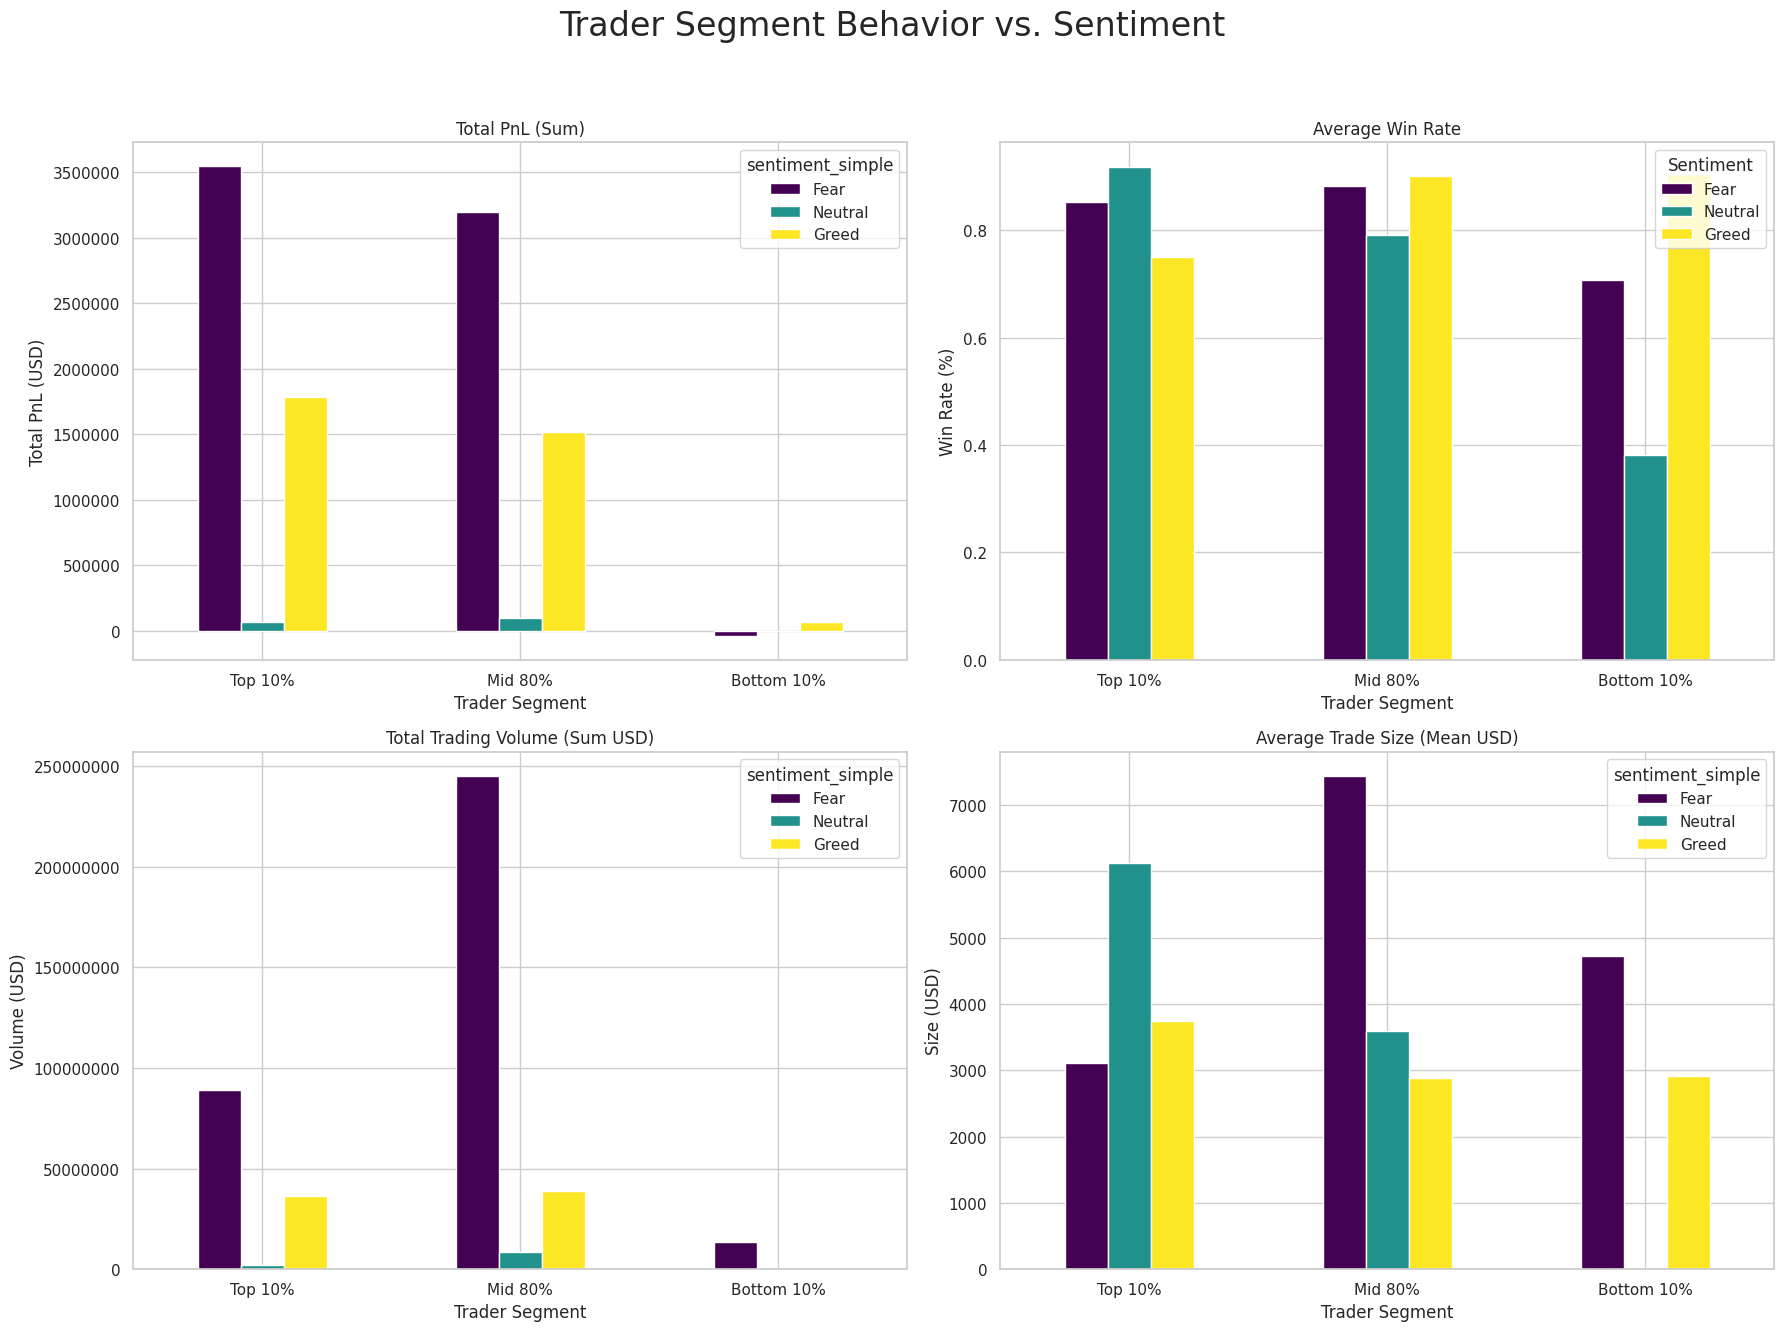

Chart 2 saved to outputs/segment_behavior_plot.png


In [58]:
# Segmented Behavior vs. Sentiment
if 'analysis_df_segmented' in locals():
    print("\n Segmented Behavior vs. Sentiment")
    segment_order = ['Top 10%', 'Mid 80%', 'Bottom 10%']
    sentiment_order = ['Fear', 'Neutral', 'Greed']

    pnl_pivot = analysis_df_segmented.groupby(
        ['Segment', 'sentiment_simple']
    )['Closed PnL'].sum().unstack()[sentiment_order].reindex(segment_order)

    win_rate_pivot = analysis_df_segmented.groupby(
        ['Segment', 'sentiment_simple']
    )['is_win'].mean().unstack()[sentiment_order].reindex(segment_order)

    volume_pivot = analysis_df_segmented.groupby(
        ['Segment', 'sentiment_simple']
    )['Size USD'].sum().unstack()[sentiment_order].reindex(segment_order)

    avg_size_pivot = analysis_df_segmented.groupby(
        ['Segment', 'sentiment_simple']
    )['Size USD'].mean().unstack()[sentiment_order].reindex(segment_order)

    print("\nTotal PnL (Sum) by Segment & Sentiment:\n", pnl_pivot)
    print("\nAverage Win Rate (Mean) by Segment & Sentiment:\n", win_rate_pivot)
    print("\nTotal Trading Volume (Sum USD) by Segment & Sentiment:\n", volume_pivot)
    print("\nAverage Trade Size (Mean USD) by Segment & Sentiment:\n", avg_size_pivot)

    fig, ax = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Trader Segment Behavior vs. Sentiment', fontsize=24)

    pnl_pivot.plot(kind='bar', ax=ax[0, 0], colormap='viridis')
    ax[0, 0].set_title('Total PnL (Sum)')
    ax[0, 0].set_ylabel('Total PnL (USD)')

    win_rate_pivot.plot(kind='bar', ax=ax[0, 1], colormap='viridis')
    ax[0, 1].set_title('Average Win Rate')
    ax[0, 1].set_ylabel('Win Rate (%)')
    ax[0, 1].legend(title='Sentiment')

    volume_pivot.plot(kind='bar', ax=ax[1, 0], colormap='viridis')
    ax[1, 0].set_title('Total Trading Volume (Sum USD)')
    ax[1, 0].set_ylabel('Volume (USD)')

    avg_size_pivot.plot(kind='bar', ax=ax[1, 1], colormap='viridis')
    ax[1, 1].set_title('Average Trade Size (Mean USD)')
    ax[1, 1].set_ylabel('Size (USD)')

    for axis in ax.flat:
        axis.set_xlabel('Trader Segment')
        axis.tick_params(axis='x', rotation=0)
        axis.ticklabel_format(style='plain', axis='y')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plot_path_2 = 'outputs/segment_behavior_plot.png'
    plt.savefig(plot_path_2)
    plt.show()
    print(f"Chart 2 saved to {plot_path_2}")
else:
    print("Segmented analysis dataframe not found.")

In [59]:

if 'analysis_df_segmented' in locals():
    csv_path = 'csv_files/final_segmented_analysis.csv'
    analysis_df_segmented.to_csv(csv_path, index=False)
    print(f"\nFinal analysis data saved to {csv_path}")
else:
    print("Segmented analysis dataframe not found.")



Final analysis data saved to csv_files/final_segmented_analysis.csv
End of Analysis Notebook
